In [1]:
# Group 10: Harihara, Wrootchit ,Zubin

# Implementation of Logistic Regression (LR) algorithm for our dataset

# We implemented the LR algorithm for our model from scratch, using the sklearn package ONLY for obtaining the performance metrics and plotting the confusion matrix

# We feel the need to mention that cross validation of logistic regression for 10 folds takes nearly 2 hours to run on Jupyter.
# Also, in the logisitc regression code only, the subtype index starts from 0
# The accuracy values here may vary slightly from what was presented during the final presentation. 
# This is because we get different values each run of the code, and we made some corrections to the code.

In [2]:
# Importing the necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For obtaining the precison,recall & f1 score values, and plotting the confusion matrix only
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay 

In [3]:
# Before running the code, please download and place the dataset .csv file in the directory.
# The downlaod link is given below.

# 'https://sbcb.inf.ufrgs.br/data/cumida/Genes/Leukemia/GSE28497/Leukemia_GSE28497.csv'

In [4]:
# Loading the dataset from the downloaded CSV file and checking what the dataframe looks like
raw_data_df = pd.read_csv('Leukemia_GSE28497.csv')
print(raw_data_df.head())

            samples        type  1007_s_at   1053_at    117_at    121_at  \
0  GSM705467.CEL.gz  B-CELL_ALL   7.409521  5.009216  4.173607  7.315369   
1  GSM705468.CEL.gz  B-CELL_ALL   7.177109  5.415108  4.426778  7.550818   
2  GSM705469.CEL.gz  B-CELL_ALL   6.564918  5.248020  4.252414  7.175169   
3  GSM705470.CEL.gz  B-CELL_ALL   6.872028  5.155963  4.388849  7.365933   
4  GSM705471.CEL.gz  B-CELL_ALL   7.402105  5.509826  4.284291  7.214947   

   1255_g_at   1294_at   1316_at   1320_at  ...  AFFX-r2-Hs28SrRNA-5_at  \
0   3.185411  7.620644  3.731541  3.471587  ...                2.968822   
1   3.134181  7.685723  3.907953  3.650995  ...                2.982888   
2   3.017718  7.956261  3.354557  3.302989  ...                2.897425   
3   3.031735  7.830002  3.508926  3.412491  ...                3.024722   
4   2.925269  7.789838  3.610425  3.362593  ...                3.259802   

   AFFX-r2-Hs28SrRNA-M_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
0                3.22

In [5]:
# Mapping the labels to integers
label_dict = {label: i for i, label in enumerate(np.unique(raw_data_df['type']))}
raw_data_df['type'] = raw_data_df['type'].map(label_dict)

# Extracting the input features and the labels
X = raw_data_df.iloc[:, 2:].values
y = raw_data_df.iloc[:, 1].values

# Normalizing the features to have zero mean and unit variance
mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0)
X = (X - mu) / sigma

# Defining the percentage of data to be used for testing (75% for training and 25% for testing)
test_size = 0.25

# Computing the number of samples in the testing set
num_test_samples = int(X.shape[0] * test_size)

# Shuffling the dataset
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

# Splitting the dataset into training and testing sets
X_train, X_test = X[num_test_samples:], X[:num_test_samples]
y_train, y_test = y[num_test_samples:], y[:num_test_samples]

# Printing the sizes of the training and testing sets
print(f'Training set size = {X_train.shape[0]}')
print(f'Testing set size = {X_test.shape[0]}')

# Defining the number of features and classes
num_features = X.shape[1]
num_classes = np.unique(y).shape[0]

# Initializing the weights with small random values
W = np.random.randn(num_features, num_classes) * 0.01
b = np.zeros(num_classes)


Training set size = 211
Testing set size = 70


In [6]:
# sigmoid() function maps any real-valued number to a value between 0 and 1
def sigmoid(z):
    epsilon = 1e-7
    return np.clip(1 / (1 + np.exp(-z)), epsilon, 1 - epsilon)

# binary_cross_entropy_loss() function computes the binary cross-entropy loss between the predicted y_pred and true y_true values
# Penalizing models that are confident but incorrect
def binary_cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[0]
    loss = -1 * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m
    return loss

# gradient_descent() function performs a single step of gradient descent on the logistic regression parameters W and b, using the predicted y_pred values, true y values, a learning rate and regularization strength alpha.
# It returns the updated W and b values.
def gradient_descent(X, y, y_pred, W, b, learning_rate, alpha):
    m = X.shape[0]
    dW = (1 / m) * np.dot(X.T, (y_pred - y))
    db = (1 / m) * np.sum(y_pred - y, axis=0)
    W = W - learning_rate * (dW + alpha * W)
    b = b - learning_rate * db
    return W, b

# train() function trains the LR classifier using gradient descent on the given data X & y for num_iterations, and returns the final W and b values.
# It also prints out the loss every 10000 iterations
def train(X, y, W, b, num_iterations, learning_rate, alpha):
    for i in range(num_iterations):
        z = np.dot(X, W) + b
        y_pred = sigmoid(z)
        loss = binary_cross_entropy_loss(y_pred, y) + (alpha / 2) * np.sum(W ** 2)
        W, b = gradient_descent(X, y, y_pred, W, b, learning_rate, alpha)

        if (i + 1) % 10000 == 0:
            print(f'Iteration {i + 1}: loss = {loss:.6f}')

    return W, b

# predict() function returns the predicted binary class labels (0 or 1) for data X, using the logistic regression parameters W & b
def predict(X, W, b):
    z = np.dot(X, W) + b
    y_pred = sigmoid(z)
    return (y_pred > 0.5).astype(int)

In [7]:
# Defining the number of subtypes
num_subtypes = num_classes

In [8]:
# Initializing the arrays to store the results for accuracy, precision, recall, f1 scores and AUC scores
accuracies = np.zeros(num_subtypes)
precisions = np.zeros(num_subtypes)
recalls = np.zeros(num_subtypes)
f1_scores = np.zeros(num_subtypes)
auc_scores = np.zeros(num_subtypes)
fpr_all = []
tpr_all = []

# Initializing the arrays to store the weights and biases for each subtype
W_all = np.zeros((num_subtypes, X_train.shape[1], 1))
b_all = np.zeros((num_subtypes, 1))

# Training and testing the model for each subtype
for target_subtype in range(num_subtypes):
    
    # Printing the current subtype being iterated over
    print("----------","Subtype:", target_subtype,"----------")
    
    # Preparing the data
    y_train_binary = (y_train == target_subtype).astype(int)
    y_test_binary = (y_test == target_subtype).astype(int)

    # Initializing the weights and bias
    np.random.seed(42)
    W = np.random.randn(X_train.shape[1], 1)
    b = np.zeros((1,))

    # Initializing the paramters and training the model
    num_iterations = 50000
    learning_rate = 0.15
    alpha = 0.003  # Regularization strength
    W, b = train(X_train, y_train_binary.reshape(-1, 1), W, b, num_iterations, learning_rate, alpha)
    
    
    # Storing the trained weights and biases for the current subtype
    W_all[target_subtype] = W
    b_all[target_subtype] = b

    # Testing the model on the testing set
    y_pred = predict(X_test, W, b)
    
    # Computing the accuracy of the One vs rest LR classifier for that subtype
    accuracies[target_subtype] = np.mean(y_pred.reshape(-1) == y_test_binary)

    # Computing the precision, recall, and F1 score using scikit-learn
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_binary, y_pred)

    # Storing the results for Positive class
    precisions[target_subtype] = precision[1] 
    recalls[target_subtype] = recall[1] 
    f1_scores[target_subtype] = f1[1] 

    # Computing the AUC score and ROC curve
    y_score = sigmoid(np.dot(X_test, W) + b)
    fpr, tpr, _ = roc_curve(y_test_binary, y_score)
    auc_scores[target_subtype] = roc_auc_score(y_test_binary, y_score)
    fpr_all.append(fpr)
    tpr_all.append(tpr)
    
    # Printing the completion of training and tesing for current subtype being iterated over
    print("----------","Done for Subtype:",target_subtype,"----------")



---------- Subtype: 0 ----------
Iteration 10000: loss = 0.005810
Iteration 20000: loss = 0.001565
Iteration 30000: loss = 0.001451
Iteration 40000: loss = 0.001363
Iteration 50000: loss = 0.001297
---------- Done for Subtype: 0 ----------
---------- Subtype: 1 ----------
Iteration 10000: loss = 0.005515
Iteration 20000: loss = 0.001268
Iteration 30000: loss = 0.001140
Iteration 40000: loss = 0.001028
Iteration 50000: loss = 0.000930
---------- Done for Subtype: 1 ----------
---------- Subtype: 2 ----------
Iteration 10000: loss = 0.005583
Iteration 20000: loss = 0.001316
Iteration 30000: loss = 0.001172
Iteration 40000: loss = 0.001049
Iteration 50000: loss = 0.000943
---------- Done for Subtype: 2 ----------
---------- Subtype: 3 ----------
Iteration 10000: loss = 0.006442
Iteration 20000: loss = 0.001739
Iteration 30000: loss = 0.001349
Iteration 40000: loss = 0.001096
Iteration 50000: loss = 0.000928
---------- Done for Subtype: 3 ----------
---------- Subtype: 4 ----------
Iterati

In [9]:
# Zero array to store the predicted probabilities for each test sample for each subtype.
y_pred_all = np.zeros((X_test.shape[0], num_subtypes))

# Iterating over each subtype and computing the prediction for each test sample using the logistic regression parameters W_all and b_all for that subtype
for target_subtype in range(num_subtypes):
    y_pred_all[:, target_subtype] = sigmoid(np.dot(X_test, W_all[target_subtype]) + b_all[target_subtype]).reshape(-1)

# Obtaining the subtype with the highest predicted probability for each test sample
y_pred_all = np.argmax(y_pred_all, axis=1)

# Calculating the confusion matrix for all subtypes
confusion_matrix_result = confusion_matrix(y_test, y_pred_all)

# Print the confusion matrix
print("Confusion matrix for all subtypes:")
print(confusion_matrix_result)

Confusion matrix for all subtypes:
[[14  1  0  0  0  0  0]
 [ 0 12  0  0  0  0  0]
 [ 0  0 13  1  0  0  0]
 [ 3  0  0  3  0  0  0]
 [ 0  0  0  0  6  0  0]
 [ 0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  7]]


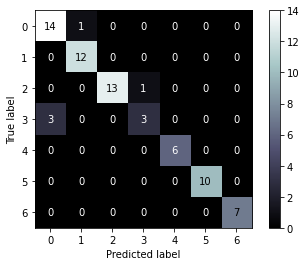

In [10]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_all, cmap = 'bone')


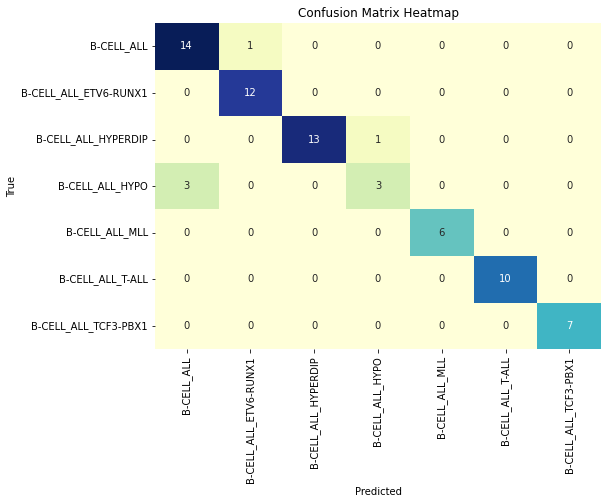

In [11]:
# Plot the heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap="YlGnBu", fmt='d', cbar=False, xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

Average accuracy for the LR classifer = 83.67%
Subtype 0: precision = 53.57%, recall = 100.00%, F1 score = 69.77%, AUC = 99.52%
Subtype 1: precision = 54.55%, recall = 100.00%, F1 score = 70.59%, AUC = 100.00%
Subtype 2: precision = 63.64%, recall = 100.00%, F1 score = 77.78%, AUC = 99.62%
Subtype 3: precision = 23.53%, recall = 66.67%, F1 score = 34.78%, AUC = 83.85%
Subtype 4: precision = 24.00%, recall = 100.00%, F1 score = 38.71%, AUC = 100.00%
Subtype 5: precision = 90.91%, recall = 100.00%, F1 score = 95.24%, AUC = 100.00%
Subtype 6: precision = 33.33%, recall = 100.00%, F1 score = 50.00%, AUC = 100.00%


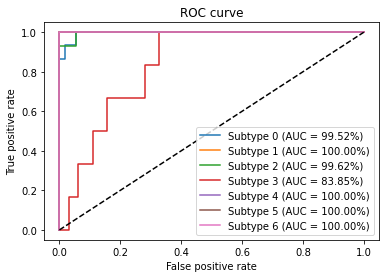

In [12]:
# Calculate the overall average accuracy for the OVR LR classifier
avg_accuracy = np.mean(accuracies)
print(f'Average accuracy for the LR classifer = {avg_accuracy:.2%}')

# Printing the precision, recall, and F1 score for each subtype
for i in range(num_subtypes):
    print(f'Subtype {i}: precision = {precisions[i]:.2%}, recall = {recalls[i]:.2%}, F1 score = {f1_scores[i]:.2%}, AUC = {auc_scores[i]:.2%}')

# Plotting the ROC curve for each subtype
for i in range(num_subtypes):
    plt.plot(fpr_all[i], tpr_all[i], label=f'Subtype {i} (AUC = {auc_scores[i]:.2%})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

In [13]:
#The implementation of the cross validation can be seen below.

In [14]:
# Defining the number of folds
k = 10

# Initializing the array to store the results
accuracies_kfold = np.zeros((num_subtypes, k))

# Performing k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)
for fold, (train_indices, test_indices) in enumerate(kf.split(X)):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    # Training and testing the model for each subtype
    for target_subtype in range(num_subtypes):
        # Printing the current fold and subtype being iterated over
        print("----------", "Fold:", fold ,"|", "Subtype:", target_subtype,"----------")
        
        # Preparing the data
        y_train_binary = (y_train == target_subtype).astype(int)
        y_test_binary = (y_test == target_subtype).astype(int)

        # Initializing the weights and bias
        np.random.seed(42)
        W = np.random.randn(X_train.shape[1], 1)
        b = np.zeros((1,))

        # Initializing the paramters and training the model
        num_iterations = 50000
        learning_rate = 0.15
        alpha = 0.003  # Regularization strength
        W, b = train(X_train, y_train_binary.reshape(-1, 1), W, b, num_iterations, learning_rate, alpha)

        # Testing the model on the testing set
        y_pred = predict(X_test, W, b)

        # Computing the accuracies
        accuracies_kfold[target_subtype, fold] = np.mean(y_pred.reshape(-1) == y_test_binary)
        
        # Printing the completion of training and tesing for current fold and subtype being iterated over
        print("----------","Done for Fold:",fold,"|"," Subtype:",target_subtype,"----------")

---------- Fold: 0 | Subtype: 0 ----------
Iteration 10000: loss = 0.006001
Iteration 20000: loss = 0.001676
Iteration 30000: loss = 0.001502
Iteration 40000: loss = 0.001377
Iteration 50000: loss = 0.001292
---------- Done for Fold: 0 |  Subtype: 0 ----------
---------- Fold: 0 | Subtype: 1 ----------
Iteration 10000: loss = 0.005645
Iteration 20000: loss = 0.001358
Iteration 30000: loss = 0.001194
Iteration 40000: loss = 0.001055
Iteration 50000: loss = 0.000936
---------- Done for Fold: 0 |  Subtype: 1 ----------
---------- Fold: 0 | Subtype: 2 ----------
Iteration 10000: loss = 0.005734
Iteration 20000: loss = 0.001422
Iteration 30000: loss = 0.001243
Iteration 40000: loss = 0.001095
Iteration 50000: loss = 0.000972
---------- Done for Fold: 0 |  Subtype: 2 ----------
---------- Fold: 0 | Subtype: 3 ----------
Iteration 10000: loss = 0.005839
Iteration 20000: loss = 0.001160
Iteration 30000: loss = 0.000910
Iteration 40000: loss = 0.000790
Iteration 50000: loss = 0.000723
---------

Iteration 30000: loss = 0.000994
Iteration 40000: loss = 0.000863
Iteration 50000: loss = 0.000792
---------- Done for Fold: 4 |  Subtype: 3 ----------
---------- Fold: 4 | Subtype: 4 ----------
Iteration 10000: loss = 0.006478
Iteration 20000: loss = 0.001650
Iteration 30000: loss = 0.001174
Iteration 40000: loss = 0.000860
Iteration 50000: loss = 0.000651
---------- Done for Fold: 4 |  Subtype: 4 ----------
---------- Fold: 4 | Subtype: 5 ----------
Iteration 10000: loss = 0.004948
Iteration 20000: loss = 0.000809
Iteration 30000: loss = 0.000766
Iteration 40000: loss = 0.000727
Iteration 50000: loss = 0.000690
---------- Done for Fold: 4 |  Subtype: 5 ----------
---------- Fold: 4 | Subtype: 6 ----------
Iteration 10000: loss = 0.006214
Iteration 20000: loss = 0.001638
Iteration 30000: loss = 0.001279
Iteration 40000: loss = 0.001011
Iteration 50000: loss = 0.000810
---------- Done for Fold: 4 |  Subtype: 6 ----------
---------- Fold: 5 | Subtype: 0 ----------
Iteration 10000: loss 

Iteration 10000: loss = 0.006018
Iteration 20000: loss = 0.001689
Iteration 30000: loss = 0.001512
Iteration 40000: loss = 0.001386
Iteration 50000: loss = 0.001302
---------- Done for Fold: 9 |  Subtype: 0 ----------
---------- Fold: 9 | Subtype: 1 ----------
Iteration 10000: loss = 0.005627
Iteration 20000: loss = 0.001349
Iteration 30000: loss = 0.001190
Iteration 40000: loss = 0.001054
Iteration 50000: loss = 0.000937
---------- Done for Fold: 9 |  Subtype: 1 ----------
---------- Fold: 9 | Subtype: 2 ----------
Iteration 10000: loss = 0.005678
Iteration 20000: loss = 0.001385
Iteration 30000: loss = 0.001218
Iteration 40000: loss = 0.001078
Iteration 50000: loss = 0.000960
---------- Done for Fold: 9 |  Subtype: 2 ----------
---------- Fold: 9 | Subtype: 3 ----------
Iteration 10000: loss = 0.005809
Iteration 20000: loss = 0.001162
Iteration 30000: loss = 0.000918
Iteration 40000: loss = 0.000798
Iteration 50000: loss = 0.000731
---------- Done for Fold: 9 |  Subtype: 3 ----------

In [15]:
# Initializing list to store classifer accruacy over all k values
avg_acc_list=[]

# Displaying and storing  the classifer accruacy over all k values
for i in range (k):
    print("Avg Acc across subtypes at k=",i,";",np.mean(accuracies_kfold[:,i]))
    avg_acc_list.append(np.mean(accuracies_kfold[:,i]))


Avg Acc across subtypes at k= 0 ; 0.9261083743842364
Avg Acc across subtypes at k= 1 ; 0.9183673469387756
Avg Acc across subtypes at k= 2 ; 0.8877551020408163
Avg Acc across subtypes at k= 3 ; 0.8928571428571429
Avg Acc across subtypes at k= 4 ; 0.8979591836734694
Avg Acc across subtypes at k= 5 ; 0.9183673469387755
Avg Acc across subtypes at k= 6 ; 0.9591836734693878
Avg Acc across subtypes at k= 7 ; 0.9081632653061226
Avg Acc across subtypes at k= 8 ; 0.923469387755102
Avg Acc across subtypes at k= 9 ; 0.8571428571428571


In [17]:
print("Avg Accuracy after 10-fold cross validation:", np.mean(avg_acc_list)*100)

Avg Accuracy after 10-fold cross validation: 90.89373680506687


In [ ]:
# As we can see, we are able to obtain the confusion matrix for the 7 classes of interest in our dataset. We also have the precion recall and f1 score of each class
# We also have the overall accuracy of the LR model. 
# A detailed explanation of the results can be found in the report submitted.